<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58e52000 @  0x7efc97c7d2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 19.5MB/s 
    100% |████████████████████████████████| 2.0MB 5.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 95 (delta 46), reused 48 (delta 18), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [0]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

1


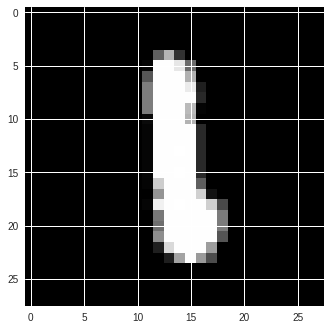

In [23]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(5)


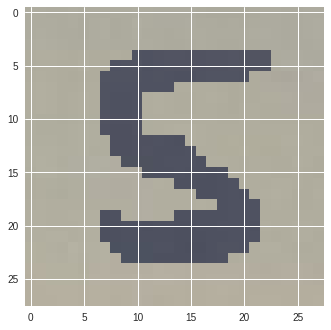

In [28]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
epochs=10

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)
criterions = Criterions(criterion, criterion_domain)
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device)

In [76]:
test_history = defaultdict(lambda:[])
train_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, train_history=train_history, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.319117, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.567189, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.431419, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.434259, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.317828, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 1.3736, Accuracy: 5940/10000 (59%)

Source Domain Test set: Average loss: 0.1187, Accuracy: 9626/10000 (96%)

Domains predictor:  Accuracy: 13114/20000 (66%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.336456, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.300788, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.216175, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.503279, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.302902, p: 0.18533 lambd: 

In [77]:
mnist_pred = nn.Sequential(model_f, model_c)
test_model(mnist_pred, device, criterions, mnist_m_test_loader)


Test set: Average loss: 0.8750, Accuracy: 7581/10000 (76%)



In [78]:
mnist_pred = nn.Sequential(model_f, model_c)
test_model(mnist_pred, device, criterions, test_loader)


Test set: Average loss: 0.0569, Accuracy: 9828/10000 (98%)



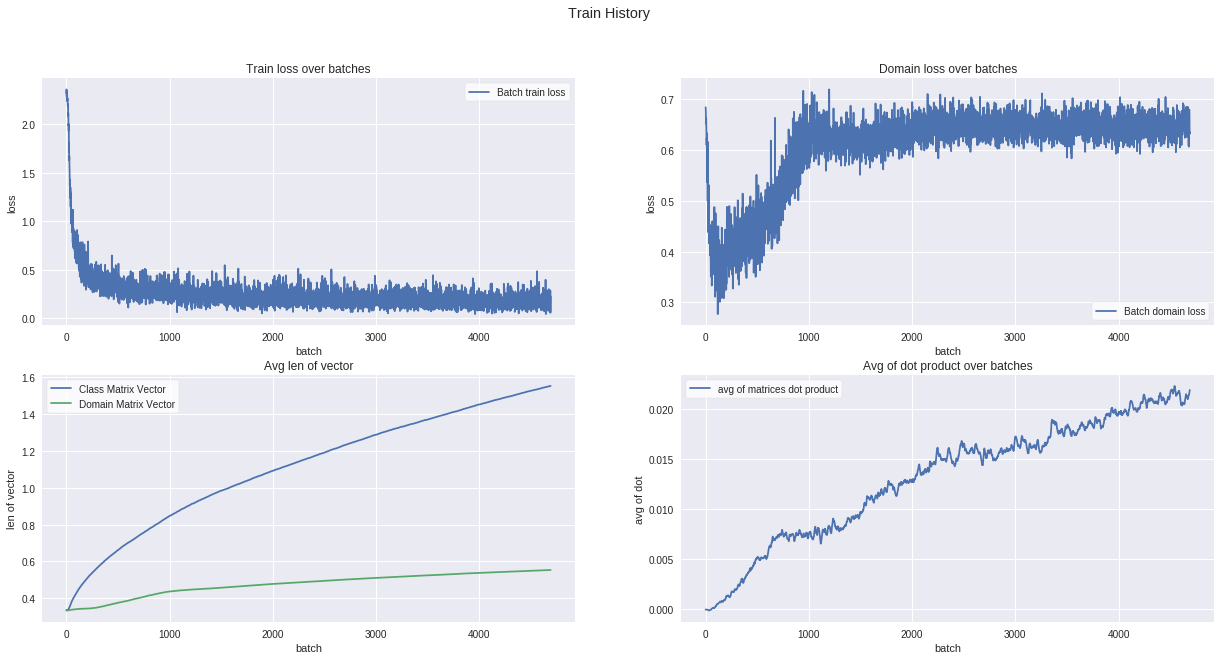

In [79]:
plots.plotTraining(train_history)

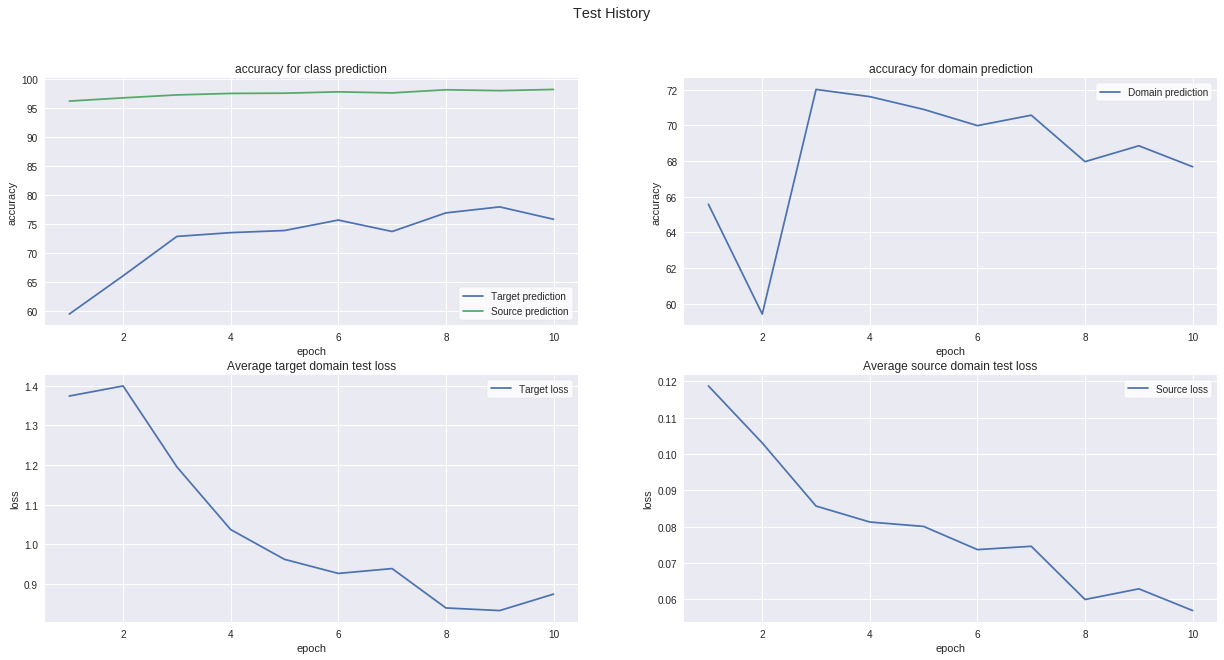

In [80]:
plots.plotTest(test_history)

In [0]:
domain_pred = models.DomainPredictor().to(device)
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [83]:
domain_train_history = defaultdict(lambda:[])
mnist_domain_trainer.train(4, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.764858

Domains predictor:  Accuracy: 16177/20000 (81%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.511136

Domains predictor:  Accuracy: 16969/20000 (85%)

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.380850

Domains predictor:  Accuracy: 17377/20000 (87%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.330907

Domains predictor:  Accuracy: 17459/20000 (87%)



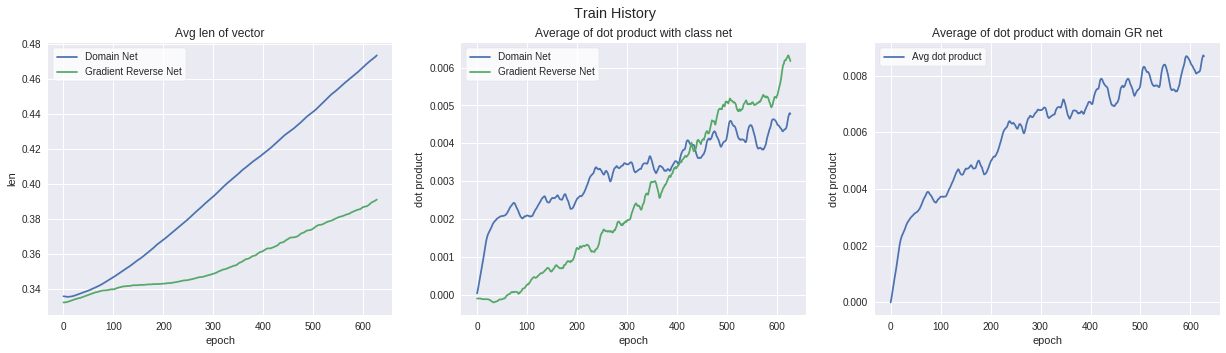

In [84]:
plots.plotDomainTraining(domain_train_history, train_history)

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(model_d.fc1.weight, 0, 1)), 2))

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [87]:
test_history2 = defaultdict(lambda:[])
train_history2 = defaultdict(lambda:[])
trainer_next.train(epochs, loaders, mtx_dot, train_history=train_history2, test_history=test_history2)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.145789, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.130204, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.183040, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.115915, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.101314, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 0.8162, Accuracy: 7732/10000 (77%)

Source Domain Test set: Average loss: 0.0564, Accuracy: 9823/10000 (98%)

Domains predictor:  Accuracy: 14605/20000 (73%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.149149, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.130136, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.167908, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.237840, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.159075, p: 0.18533 lambd: 

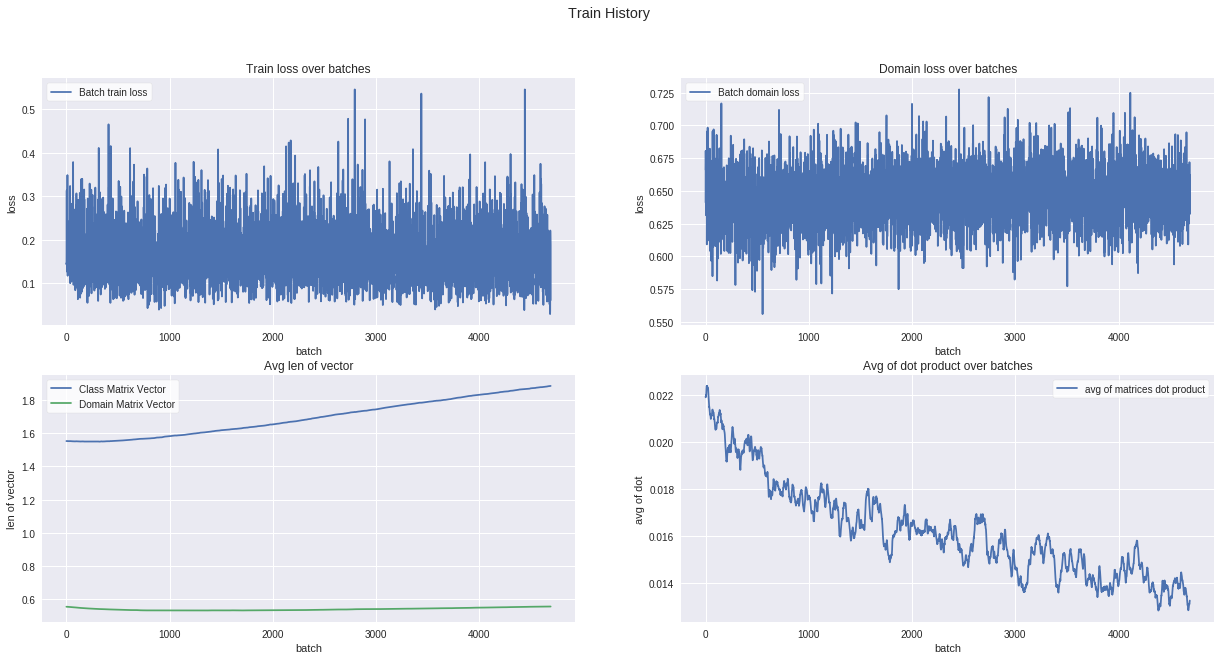

In [88]:
plots.plotTraining(train_history2)

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
def mtx_dot_len(model_c_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.fc1.weight, torch.transpose(
        model_c.fc1.weight, 0, 1)))))
  return f

In [91]:
test_history3 = defaultdict(lambda:[])
train_history3 = defaultdict(lambda:[])
f = mtx_dot_len(torch.mean(torch.diag(torch.mm(model_c.fc1.weight,
                                               torch.transpose(model_c.fc1.weight, 0, 1)))).item())
trainer_next.train(4, loaders, f, train_history=train_history3, test_history=test_history3)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.315553, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.191327, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.124649, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.081617, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.161815, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.8369, Accuracy: 7783/10000 (78%)

Source Domain Test set: Average loss: 0.0551, Accuracy: 9837/10000 (98%)

Domains predictor:  Accuracy: 13725/20000 (69%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.131787, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.229311, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.146932, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.130875, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.207478, p: 0.46333 lambd: 

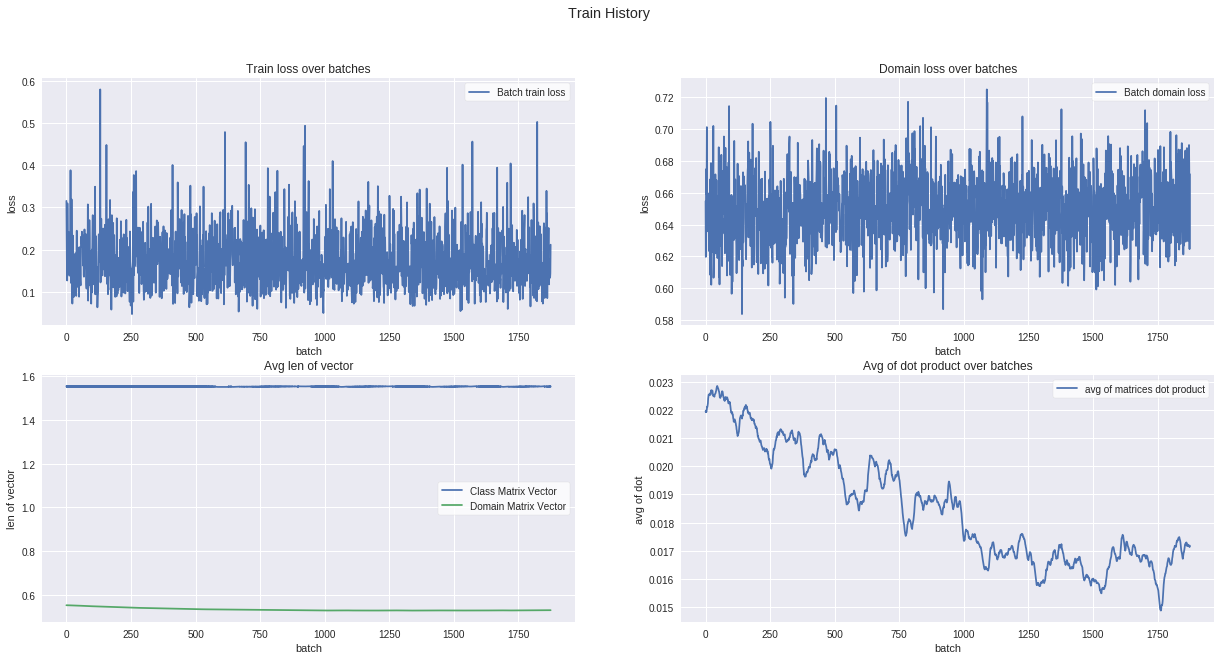

In [92]:
plots.plotTraining(train_history3)

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [94]:
test_history4 = defaultdict(lambda:[])
train_history4 = defaultdict(lambda:[])
f = mtx_dot_len(0)
trainer_next.train(4, loaders, f, train_history=train_history4, test_history=test_history4)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 1.665010, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.527115, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.245101, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.480189, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.313324, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.7625, Accuracy: 7684/10000 (77%)

Source Domain Test set: Average loss: 0.0785, Accuracy: 9758/10000 (98%)

Domains predictor:  Accuracy: 14192/20000 (71%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.263795, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.306690, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.293036, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.415523, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.287678, p: 0.46333 lambd: 

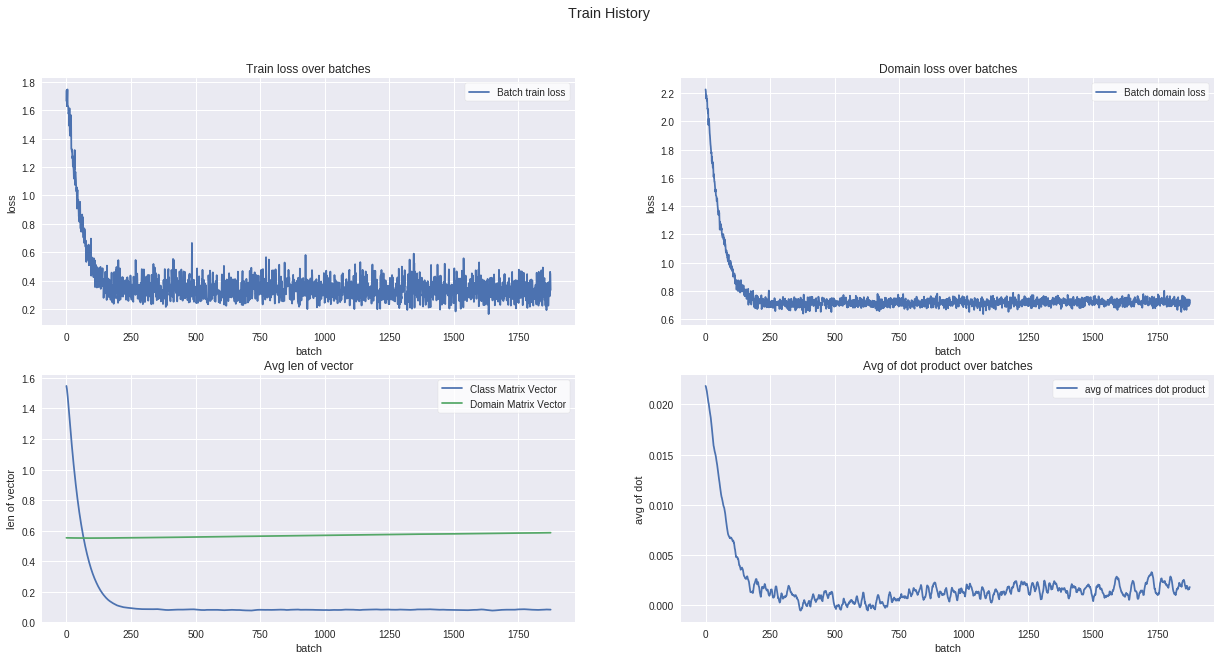

In [95]:
plots.plotTraining(train_history4)

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
def mtx_dot_lens(model_c_len, model_d_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.fc1.weight, torch.transpose(
        model_c.fc1.weight, 0, 1))))) + torch.abs(model_d_len - torch.mean(
        torch.diag(torch.mm(model_d.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)))))
  return f

In [98]:
test_history5 = defaultdict(lambda:[])
train_history5 = defaultdict(lambda:[])
f = mtx_dot_lens(0, 0)
trainer_next.train(4, loaders, f, train_history=train_history5, test_history=test_history5)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.267796, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.776409, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.514671, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.404611, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.395284, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.8093, Accuracy: 7652/10000 (77%)

Source Domain Test set: Average loss: 0.0864, Accuracy: 9729/10000 (97%)

Domains predictor:  Accuracy: 14236/20000 (71%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.378728, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.315326, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.443448, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.285396, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.291960, p: 0.46333 lambd: 

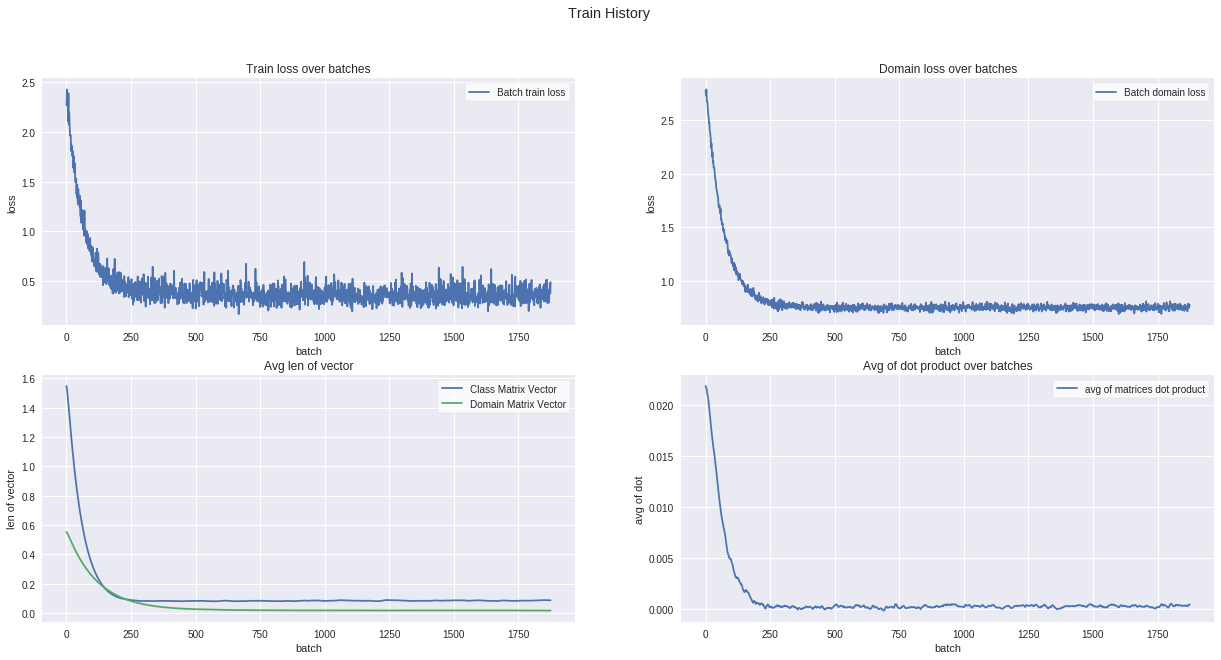

In [99]:
plots.plotTraining(train_history5)

In [0]:
model_f_adam = models.MnistFeatureExtractor().to(device)
model_c_adam = models.MnistClassPredictor().to(device)
model_d_adam = models.MnistDomain().to(device)
lr=0.001
adam_f = optim.Adam(model_f_adam.parameters(), lr=lr)
adam_c = optim.Adam(model_c_adam.parameters(), lr=lr)
adam_d = optim.Adam(model_d_adam.parameters(), lr=lr)

adam_models = Models(model_f_adam, model_c_adam, model_d_adam)
adam_optims = Optims(adam_f, adam_c, adam_d)

In [0]:
adam_trainer = trainer.Trainer(adam_models, adam_optims, criterions, device)

In [102]:
adam_test_history = defaultdict(lambda:[])
adam_train_history = defaultdict(lambda:[])
adam_trainer.train(epochs, loaders, train_history=adam_train_history, test_history=adam_test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.310268, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.563585, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.355806, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.368356, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.220912, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 1.3126, Accuracy: 6044/10000 (60%)

Source Domain Test set: Average loss: 0.0886, Accuracy: 9750/10000 (98%)

Domains predictor:  Accuracy: 17475/20000 (87%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.221749, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.311111, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.169015, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.223848, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.238733, p: 0.18533 lambd: 

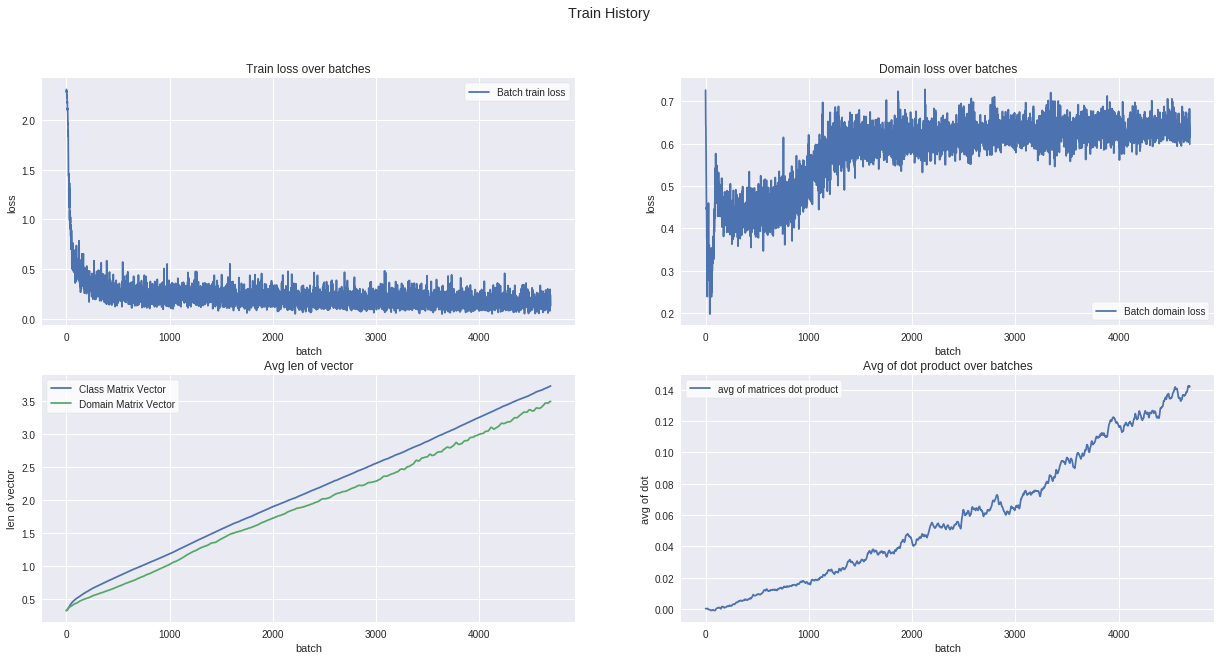

In [103]:
plots.plotTraining(adam_train_history)

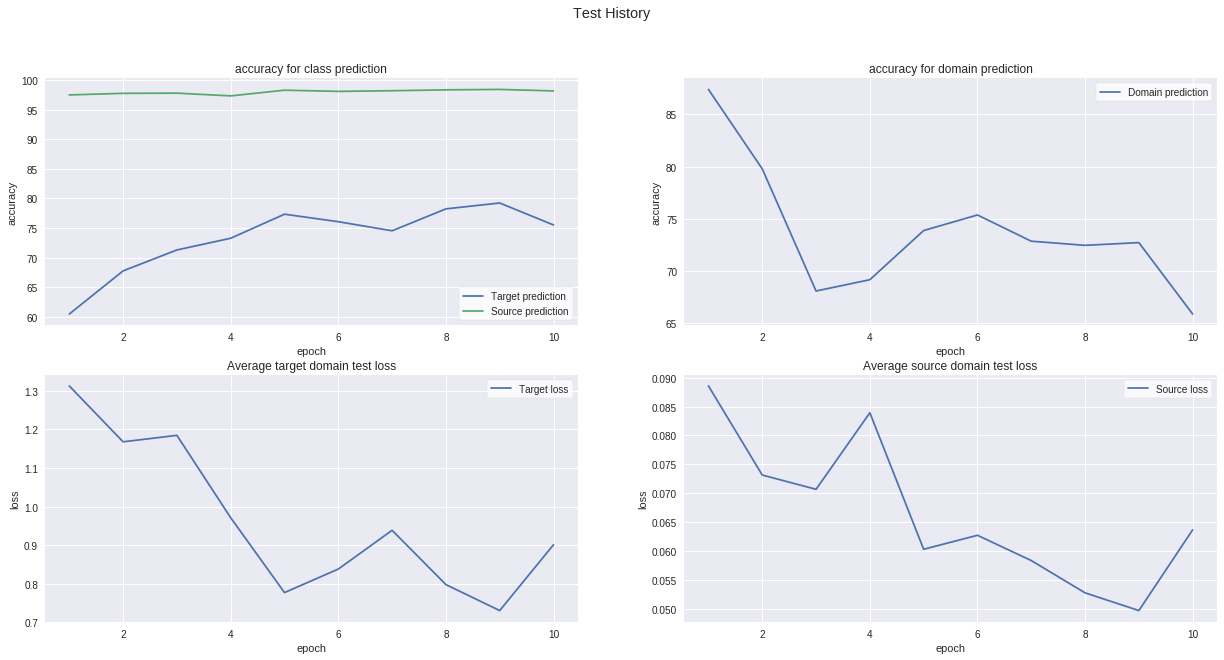

In [104]:
plots.plotTest(adam_test_history)

In [0]:
adam_trainer_next = copy.deepcopy(adam_trainer)

In [106]:
adam_test_history2 = defaultdict(lambda:[])
adam_train_history2 = defaultdict(lambda:[])
adam_trainer_next.train(5, loaders, mtx_dot, train_history=adam_train_history2, test_history=adam_test_history2)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.497996, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.109420, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.161338, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.110310, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.110124, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 0.7382, Accuracy: 7943/10000 (79%)

Source Domain Test set: Average loss: 0.0457, Accuracy: 9866/10000 (99%)

Domains predictor:  Accuracy: 14816/20000 (74%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.104482, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.151824, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.128182, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.248250, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.175119, p: 0.18533 lambd: 

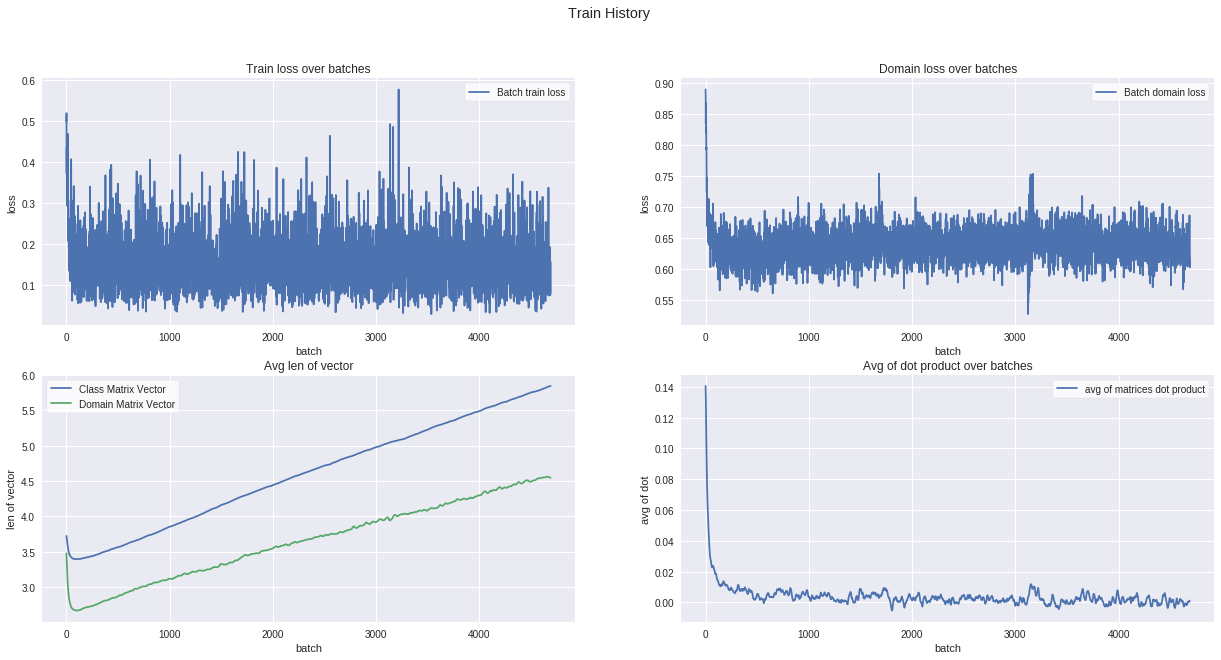

In [126]:
plots.plotTraining(adam_train_history2)

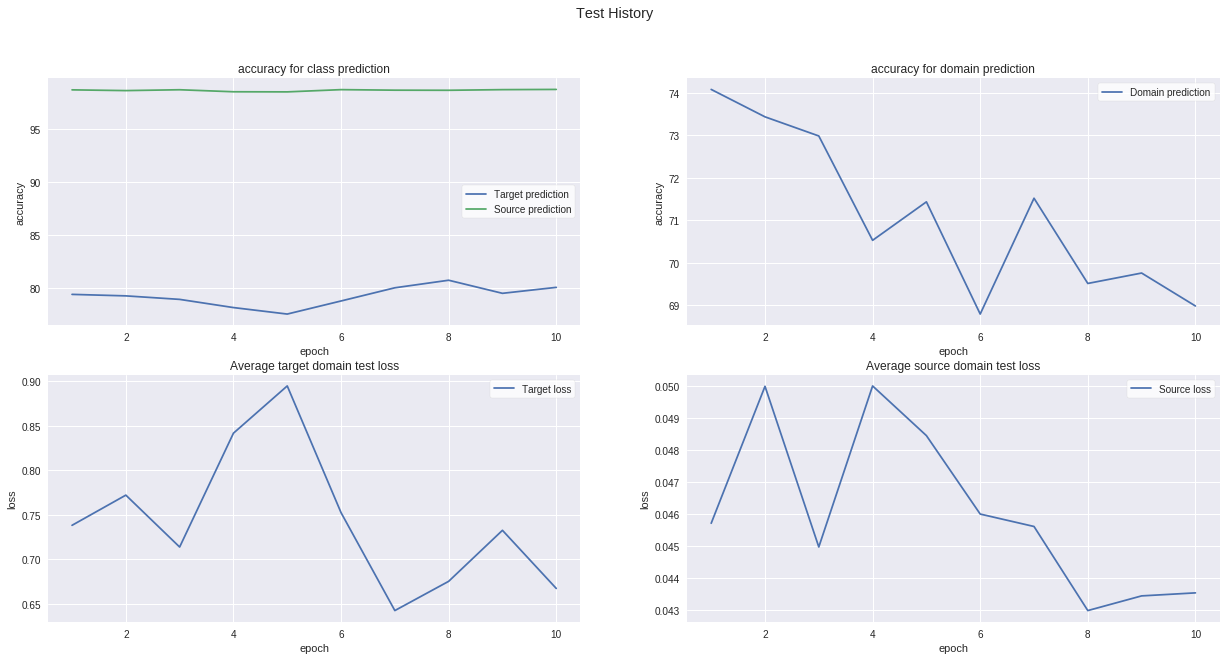

In [127]:
plots.plotTest(adam_test_history2)

In [0]:
lr=0.01
new_gr_model = models.MnistDomain()
new_gr_model.load_state_dict(domain_pred.state_dict())
new_gr_model = new_gr_model.to(device)
new_optim_d = optim.SGD(new_gr_model.parameters(), lr=lr, momentum=momentum)

In [109]:
dom_pr = nn.Sequential(model_f, new_gr_model)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 17459/20000 (87%)



In [0]:
new_domain_train_models = Models(model_f, model_c, new_gr_model)
new_domain_train_optims = Optims(optim_f, optim_c, new_optim_d)

In [0]:
domain_trainer_next = trainer.Trainer(new_domain_train_models, new_domain_train_optims, criterions, device)

In [129]:
test_history6 = defaultdict(lambda:[])
train_history6 = defaultdict(lambda:[])
domain_trainer_next.train(5, loaders, train_history=train_history6, test_history=test_history6)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.178341, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.174815, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.101745, p: 0.08533 lambd: 0.40253
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.140085, p: 0.12800 lambd: 0.56490
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.093810, p: 0.17067 lambd: 0.69281

Target Domain Test set: Average loss: 0.7976, Accuracy: 7887/10000 (79%)

Source Domain Test set: Average loss: 0.0481, Accuracy: 9853/10000 (99%)

Domains predictor:  Accuracy: 12649/20000 (63%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.105608, p: 0.20000 lambd: 0.76159
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.140460, p: 0.24267 lambd: 0.83768
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.278003, p: 0.28533 lambd: 0.89098
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.082695, p: 0.32800 lambd: 0.92747
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.201233, p: 0.37067 lambd: 

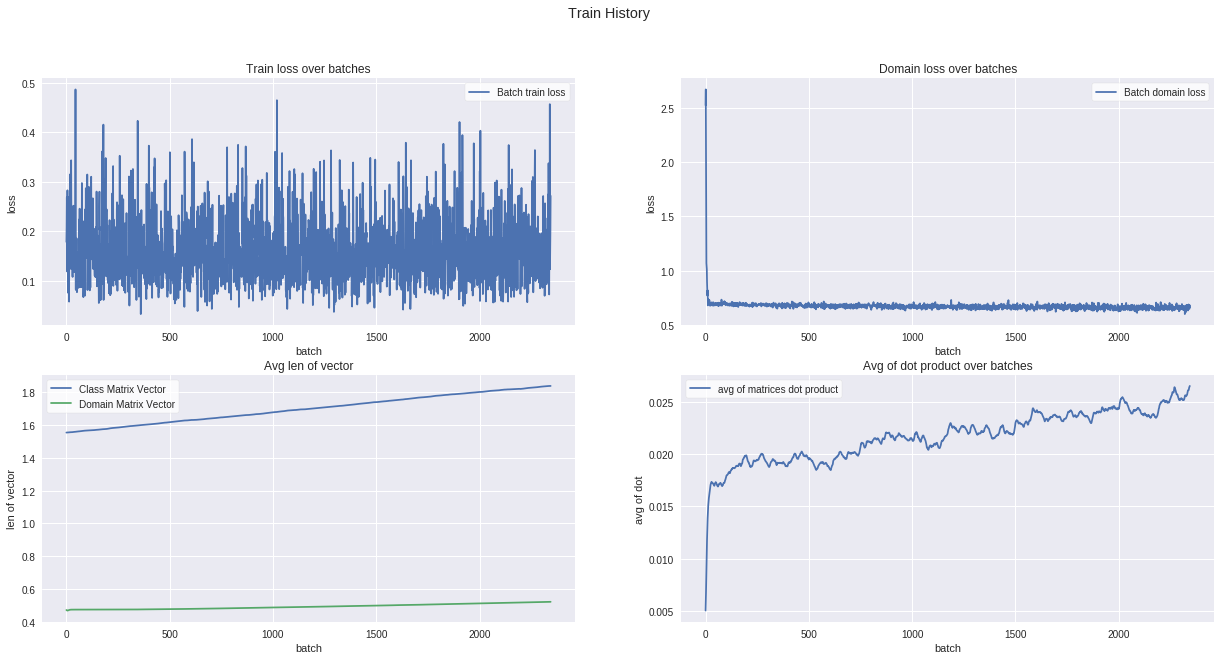

In [130]:
plots.plotTraining(train_history6)

In [133]:
dom_pr = nn.Sequential(new_domain_train_models.model_f, domain_pred)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 11919/20000 (60%)



In [134]:
dom_pr = nn.Sequential(new_domain_train_models.model_f, new_gr_model)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 13785/20000 (69%)



In [0]:
domain_pred = models.DomainPredictor().to(device)
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(new_domain_train_models.model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [137]:
domain_train_history = defaultdict(lambda:[])
mnist_domain_trainer.train(4, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.760350

Domains predictor:  Accuracy: 17105/20000 (86%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.444243

Domains predictor:  Accuracy: 18065/20000 (90%)

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.345965

Domains predictor:  Accuracy: 18097/20000 (90%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.277309

Domains predictor:  Accuracy: 18512/20000 (93%)



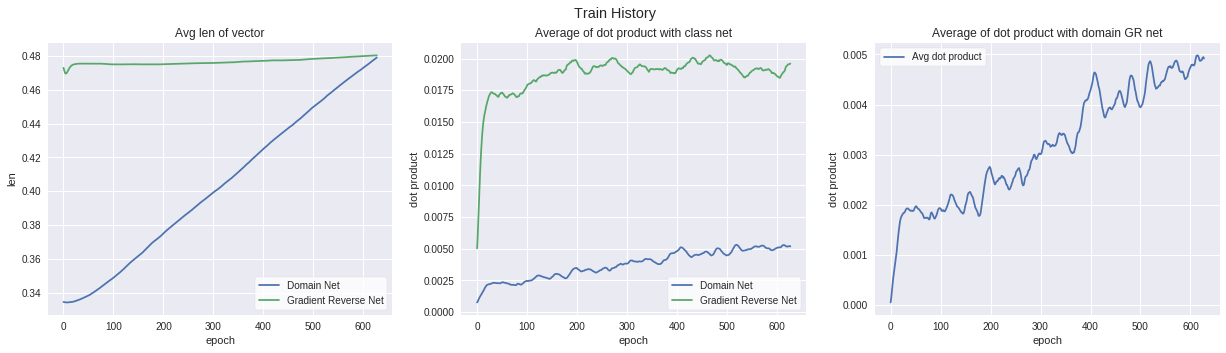

In [138]:
plots.plotDomainTraining(domain_train_history, train_history6)

In [0]:
# Tests from different training methods

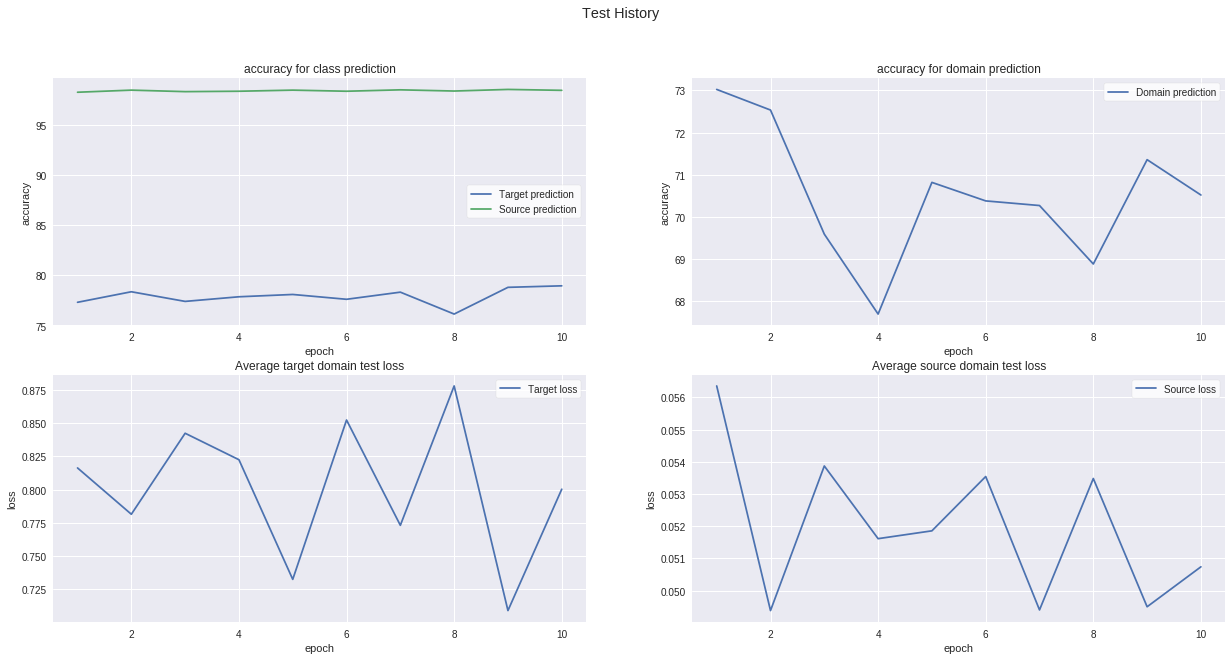

In [121]:
plots.plotTest(test_history2)

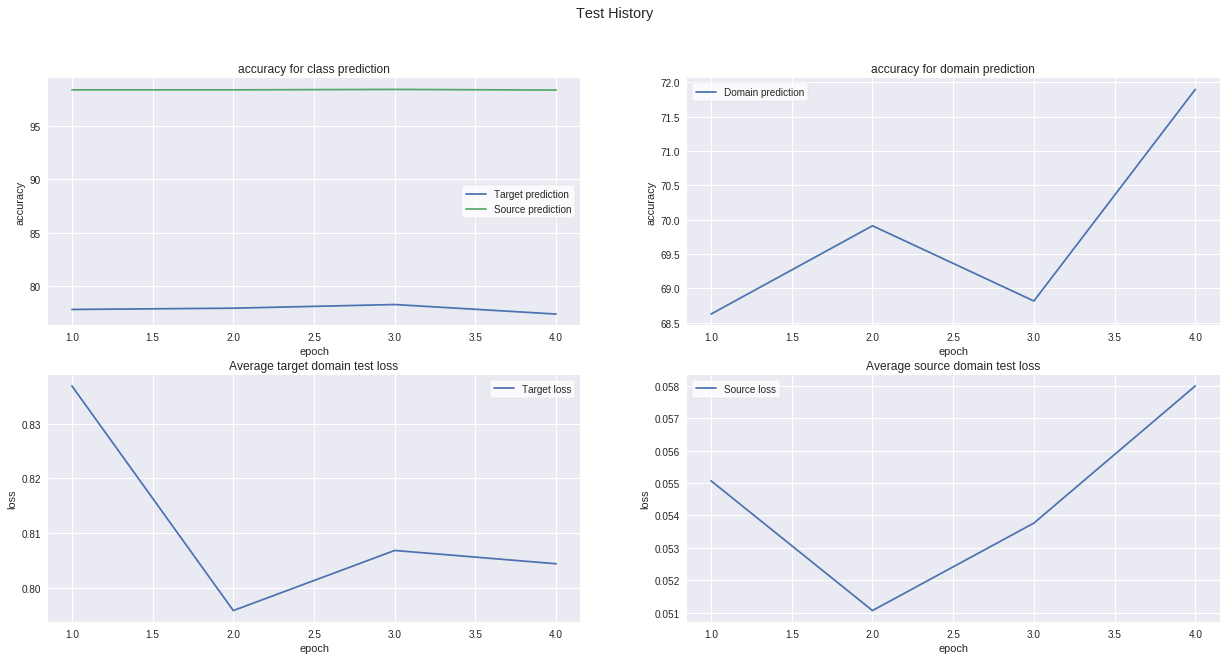

In [122]:
plots.plotTest(test_history3)

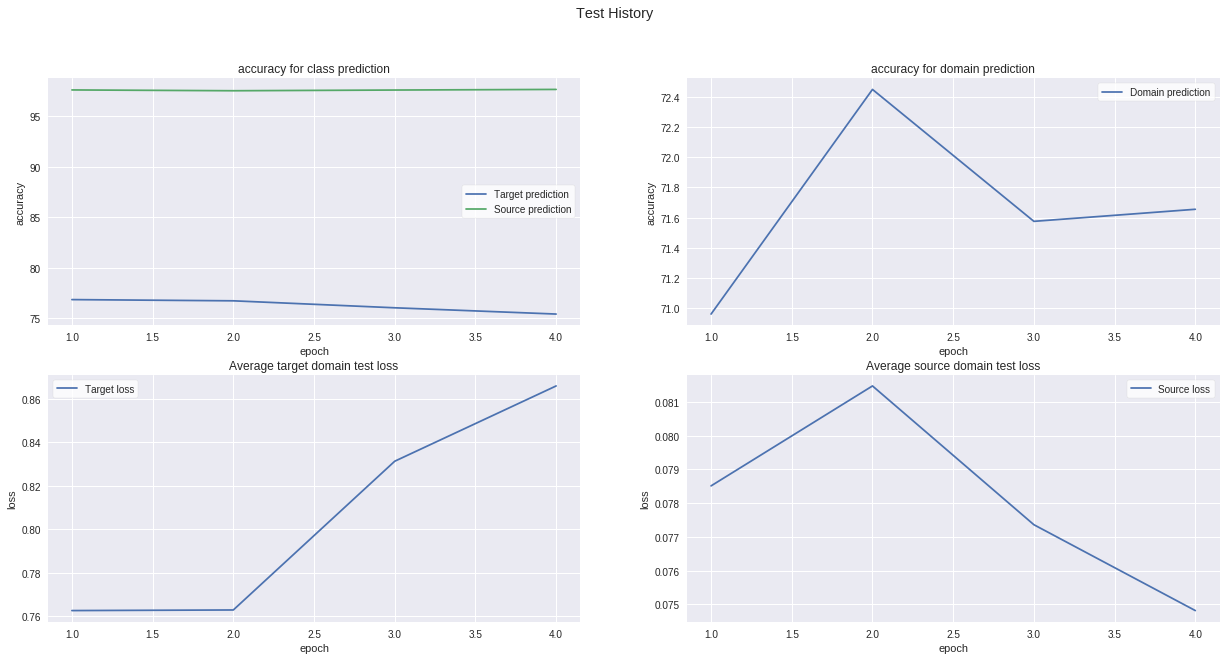

In [123]:
plots.plotTest(test_history4)

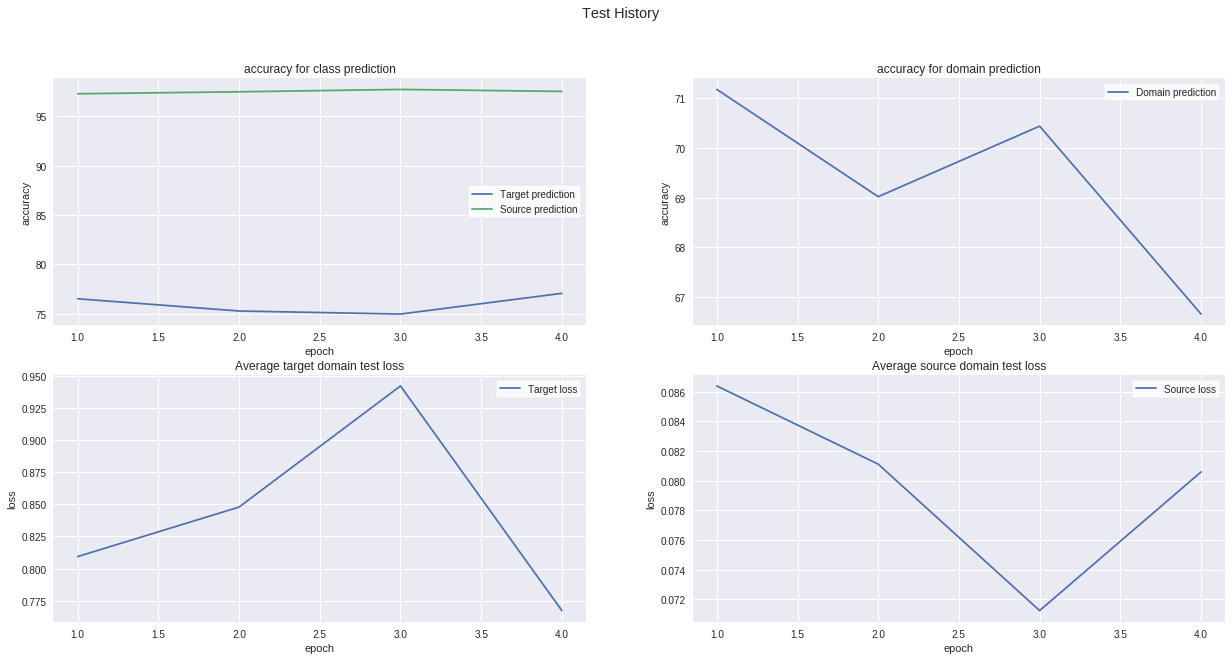

In [124]:
plots.plotTest(test_history5)

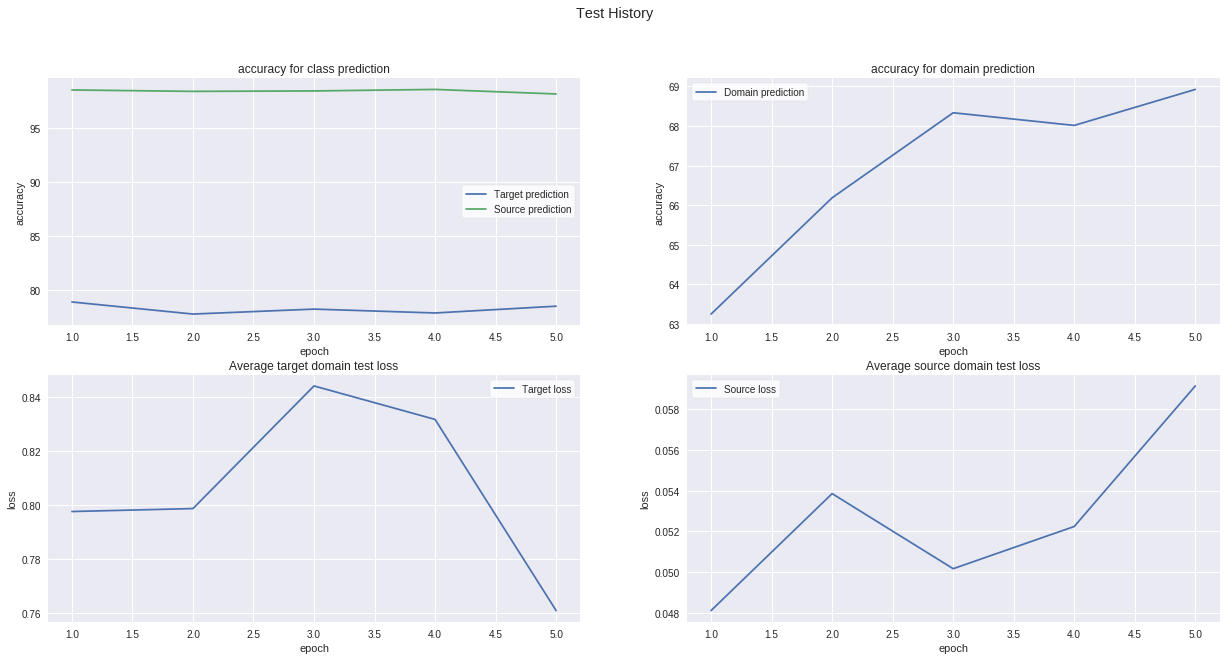

In [139]:
plots.plotTest(test_history6)

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)
criterions = Criterions(criterion, criterion_domain)
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device,
                               tune_lr=True)

In [142]:
test_history = defaultdict(lambda:[])
train_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, train_history=train_history, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.321969, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.647424, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.405104, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.392244, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.402552, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 1.3014, Accuracy: 5929/10000 (59%)

Source Domain Test set: Average loss: 0.1169, Accuracy: 9637/10000 (96%)

Domains predictor:  Accuracy: 13843/20000 (69%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.517295, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.203868, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.233297, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.260275, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.258401, p: 0.18533 lambd: 

In [143]:
mnist_pred = nn.Sequential(model_f, model_c)
test_model(mnist_pred, device, criterions, mnist_m_test_loader)


Test set: Average loss: 0.8126, Accuracy: 7700/10000 (77%)



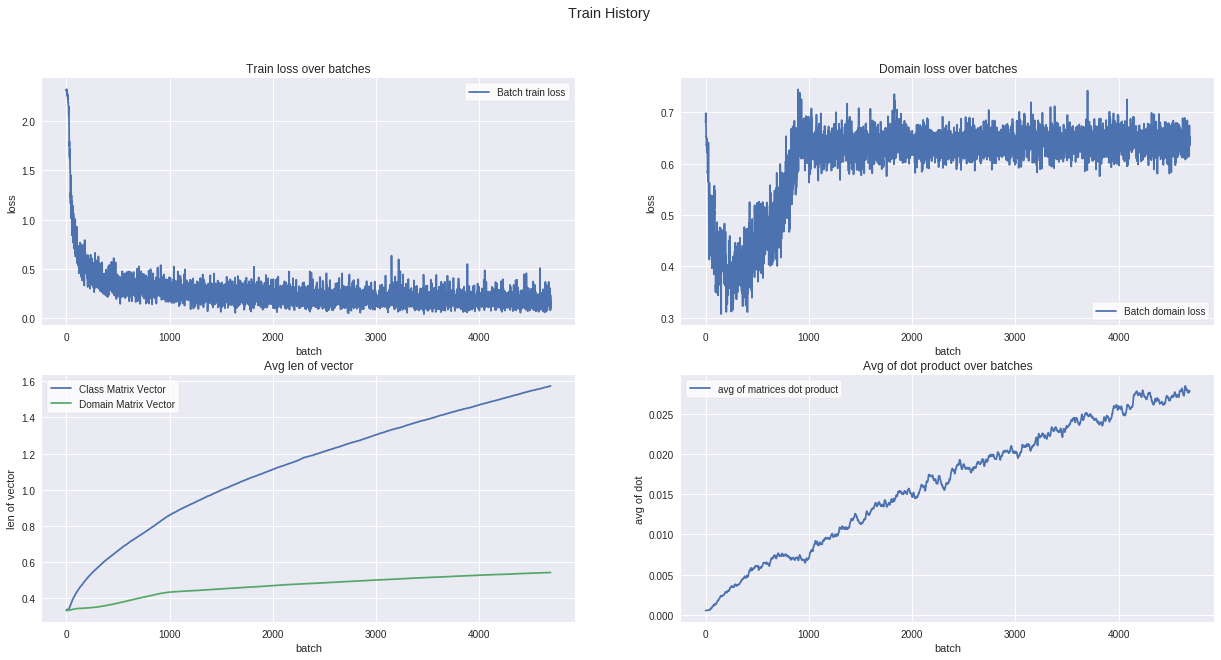

In [145]:
plots.plotTraining(train_history)

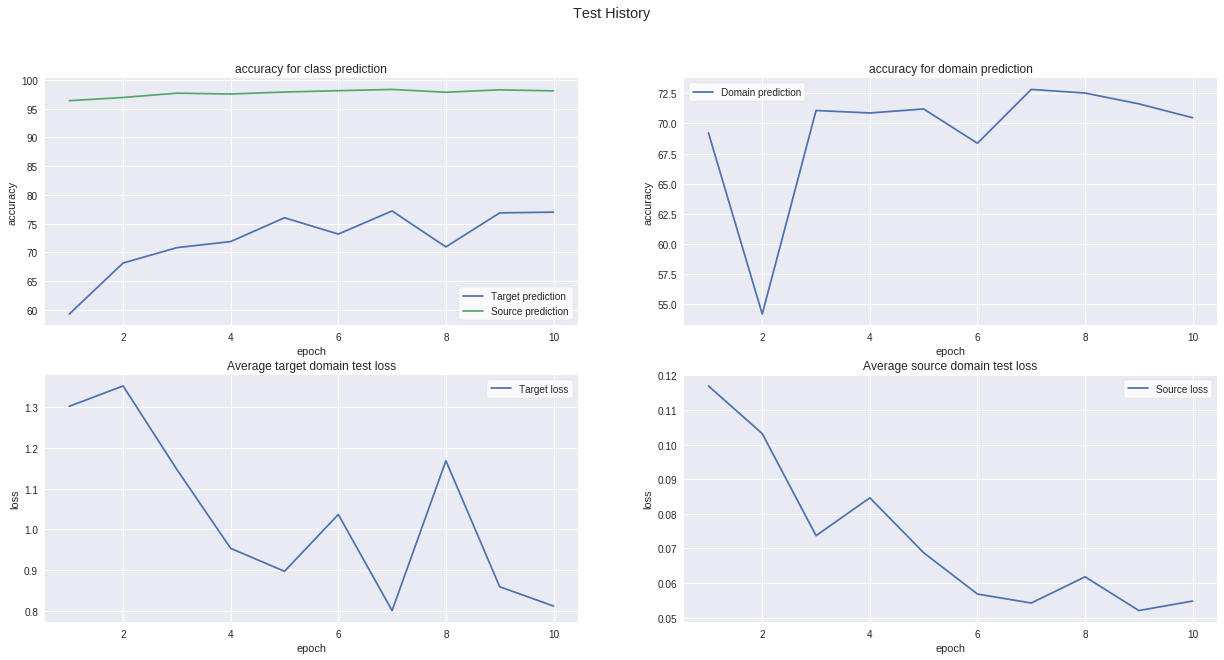

In [146]:
plots.plotTest(test_history)